In [1]:
pip install transformers datasets torch scikit-learn pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd

# Load the dataset
file_path = 'Tweets_Cleaned.csv'  # Replace with your file name
df = pd.read_csv(file_path)

# Inspect the dataset
print(df.head())


                                     text sentiment  word_count  char_count  \
0                      id responded going   neutral           3          18   
1                                     NaN  negative           1           0   
2                            bos bullying  negative           2          12   
3                   interview leave alone  negative           3          21   
4  son couldnt put release already bought  negative           6          38   

   avg_word  
0  5.333333  
1  0.000000  
2  5.500000  
3  6.333333  
4  5.500000  


In [3]:
# Rename the sentiment column to label
df.rename(columns={'sentiment': 'label'}, inplace=True)
# Map sentiment classes to integers
label_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}
df['label'] = df['label'].map(label_mapping)


In [4]:
print(df.head())


                                     text  label  word_count  char_count  \
0                      id responded going      0           3          18   
1                                     NaN      2           1           0   
2                            bos bullying      2           2          12   
3                   interview leave alone      2           3          21   
4  son couldnt put release already bought      2           6          38   

   avg_word  
0  5.333333  
1  0.000000  
2  5.500000  
3  6.333333  
4  5.500000  


In [5]:
print(df[['text', 'label']].head())

                                     text  label
0                      id responded going      0
1                                     NaN      2
2                            bos bullying      2
3                   interview leave alone      2
4  son couldnt put release already bought      2


In [6]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)


In [7]:
# Convert all text entries to strings and replace NaN or None values with an empty string
train_texts = [str(text) if pd.notnull(text) else "" for text in train_texts]
val_texts = [str(text) if pd.notnull(text) else "" for text in val_texts]

# Check a few entries to confirm they are valid
print(train_texts[:5])
print(val_texts[:5])


['oh he hilarious im commenting fact he much', 'thanks trying hoping bud trillin fest would honored guest hobnobbed', 'show house rocked saying goodbye soon', '430am west coast timegettin ready catch flight back homesoooo excited go back two fav boyzzzz puppy n bf', 'computer slooowww morning think sign go home play yard']
['enjoy family trump everything', 'kind turn buy dig deeper hole etc', 'clive birthday pat', 'congrats hey', 'texting']


In [8]:
from transformers import RobertaTokenizer

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the training and validation datasets
train_encodings = tokenizer(
    train_texts,    # Pass the cleaned list of strings
    truncation=True,
    padding=True,
    max_length=128
)

val_encodings = tokenizer(
    val_texts,    # Pass the cleaned list of strings
    truncation=True,
    padding=True,
    max_length=128
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [9]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128
)


In [10]:
print(train_texts[:5])  # Inspect first few entries
print(val_texts[:5])


['oh he hilarious im commenting fact he much', 'thanks trying hoping bud trillin fest would honored guest hobnobbed', 'show house rocked saying goodbye soon', '430am west coast timegettin ready catch flight back homesoooo excited go back two fav boyzzzz puppy n bf', 'computer slooowww morning think sign go home play yard']
['enjoy family trump everything', 'kind turn buy dig deeper hole etc', 'clive birthday pat', 'congrats hey', 'texting']


In [20]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create PyTorch datasets for training and validation
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [21]:
next(iter(train_dataset))

{'input_ids': tensor([    0,  2678,    37, 14598,  4356, 18240,   754,    37,   203,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(1)}

In [22]:
from transformers import RobertaForSequenceClassification

# Load pre-trained RoBERTa with a classification head
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=3)  # Replace 3 with the actual number of classes

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # Directory for saving model checkpoints
    num_train_epochs=10,              # Number of training epochs
    per_device_train_batch_size=64,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for validation
    learning_rate=2e-5,
    warmup_steps=250,    # Warmup steps for learning rate scheduler
    weight_decay=0.01,               # Weight decay for regularization
    logging_dir='./logs',            # Directory for logging
    evaluation_strategy="epoch",     # Evaluate the model after each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,
    metric_for_best_model="accuracy",
    run_name="roberta-sentiment"
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}


In [25]:
from transformers import Trainer, DataCollatorWithPadding

# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


<ipython-input-25-c695ee3b6b2d>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
pip install wandb

In [27]:
import wandb
wandb.init()

eval/accuracy,▁██▇▅
eval/f1,▁██▇▅
eval/loss,▅▁▁▁█
eval/runtime,█▂▄▆▁
eval/samples_per_second,▁▇▅▃█
eval/steps_per_second,▁▆▅▃█
train/epoch,▁▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▁▁▁▂▃▃▂▃█▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▄▂▂▂▂▃▂▃▃▄▂▃▃
train/learning_rate,▁▁▂▃▄▇███████▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄
train/loss,██▆▆▄▄▄▅▄▅▃▄▃▃▄▄▃▄▂▃▂▃▃▃▂▂▂▂▃▂▂▂▂▂▁▂▁▂▁▁


In [28]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.687900,0.662592,0.731623,0.730966
2,0.671000,0.643541,0.740175,0.740498
3,0.603800,0.635711,0.742904,0.742582
4,0.515000,0.641845,0.740539,0.740925
5,0.384400,0.741078,0.729803,0.729899
6,0.358300,0.809970,0.731805,0.731884
7,0.320200,0.920382,0.732351,0.732914
8,0.258900,0.994059,0.731259,0.732005
9,0.204300,1.069942,0.730713,0.731059
10,0.187200,1.124943,0.728348,0.728846


TrainOutput(global_step=3440, training_loss=0.422537173538707, metrics={'train_runtime': 5205.8824, 'train_samples_per_second': 42.229, 'train_steps_per_second': 0.661, 'total_flos': 1.60059752457984e+16, 'train_loss': 0.422537173538707, 'epoch': 10.0})

In [29]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.6357113122940063, 'eval_accuracy': 0.7429039301310044, 'eval_f1': 0.7425817113554173, 'eval_runtime': 34.0371, 'eval_samples_per_second': 161.471, 'eval_steps_per_second': 2.527, 'epoch': 10.0}


In [30]:
# Save the model and tokenizer
model.save_pretrained('./roberta-sentiment')
tokenizer.save_pretrained('./roberta-sentiment')


('./roberta-sentiment/tokenizer_config.json',
 './roberta-sentiment/special_tokens_map.json',
 './roberta-sentiment/vocab.json',
 './roberta-sentiment/merges.txt',
 './roberta-sentiment/added_tokens.json')

In [31]:
def predict_sentiment(texts):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize input texts
    tokens = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)  # Move tokens to the same device

    outputs = model(**tokens)
    predictions = torch.argmax(outputs.logits, dim=-1)
    return predictions


# Example usage
new_texts = ["This product is amazing!", "I hate the service here."]
predictions = predict_sentiment(new_texts)
print("Predictions:", predictions)


Predictions: tensor([1, 2], device='cuda:0')


In [32]:
# Re-evaluate the model on the validation dataset
validation_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation Results:", validation_results)


Validation Results: {'eval_loss': 0.6357113122940063, 'eval_accuracy': 0.7429039301310044, 'eval_f1': 0.7425817113554173, 'eval_runtime': 33.2302, 'eval_samples_per_second': 165.392, 'eval_steps_per_second': 2.588, 'epoch': 10.0}


In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions from the model on the validation dataset
predictions = trainer.predict(val_dataset)

# Extract predicted labels and true labels
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


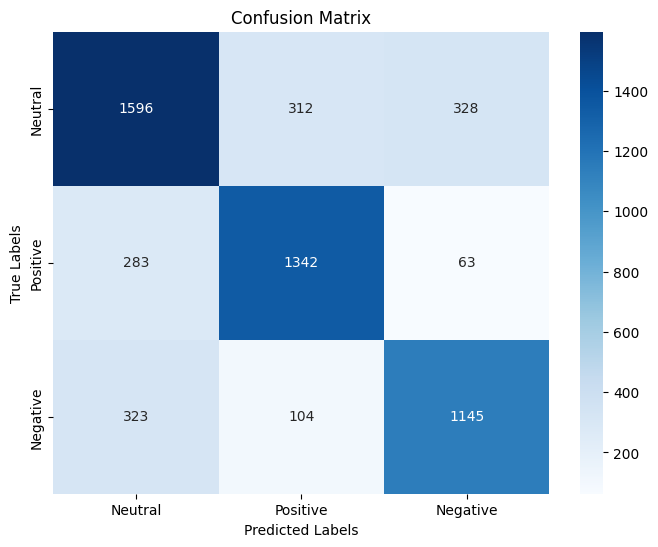

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


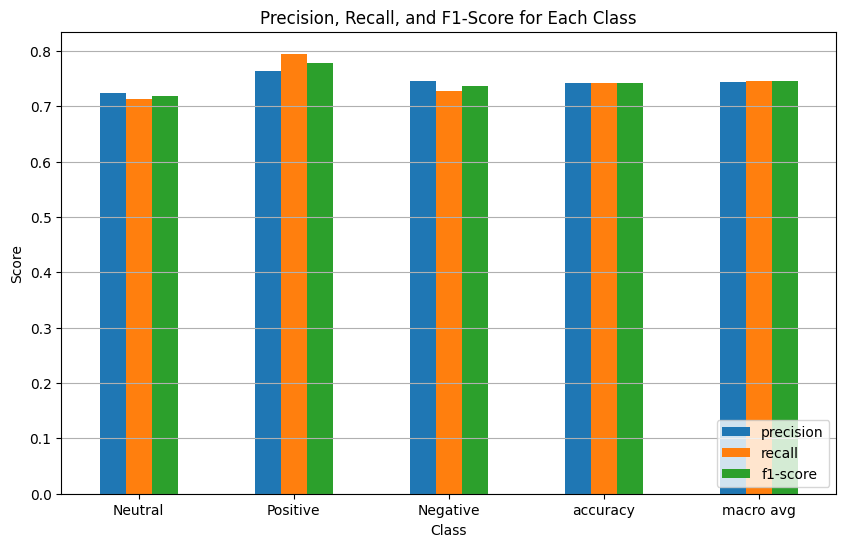

In [35]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report
report = classification_report(y_true, y_preds, target_names=['Neutral', 'Positive', 'Negative'], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot precision, recall, and F1-score
df_report[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


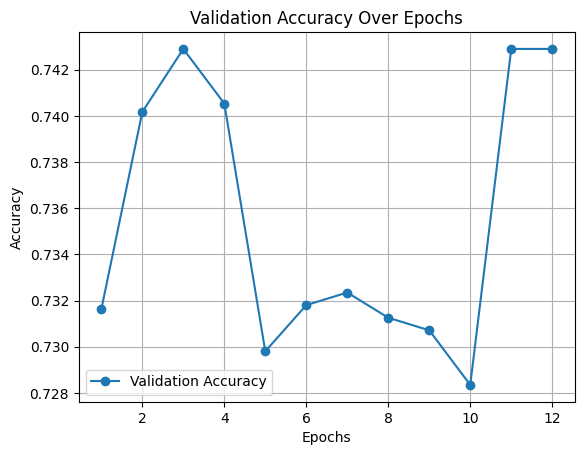

In [36]:
# Extract metrics from the training process
training_metrics = trainer.state.log_history

# Plot accuracy over epochs
accuracy = [entry['eval_accuracy'] for entry in training_metrics if 'eval_accuracy' in entry]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, marker='o', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
